# Bulk testing of piece-wise linear reduced models

$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \wt {\widetilde}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \cT {\mathcal{T}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$
$\newcommand{\rd}{\mathop{}\!\mathrm{d}}$

# Nonlinear state estimation

This notebook contains results from the script ```06_greedy_partition_accel.py```, that tests the localised reduced models on a full partition tree simulataneously, thus saving quite a bit of computational effort.

The PDE as usual is 

$$- \nabla \cdot (a(y) \nabla u)=1$$ 

on the unit cube $D=[0,1]^2$ with $a(y)$ depending on parameters in a piece-wise constant fashion. We take the average diffusion $\bar a=1$, and fix some $c=1-a_{min}<1$.

### The results 

In this test, the partition will have to be defined by a greedy algorithm.

We take the above PDE and consider now a fixed partition $D_1,\ldots,D_{16}$
say a uniform $4\times 4$ partition. Now we take

$$
a(y) = 1 + \sum_{j=1}^{16} c_j y_j  \chi_{D_j}
$$

with $c_j = \gamma j^{-s}$, meaning $s$ makes the problem anisotropic, for example
$s=1,2$. Here we test with $\gamma = 0.9, 0.99$.

So we expect that adaptive refinement of the parameter domain
should only be needed in the first coordinate $y_1$, at least for the first
steps of subdividing the domain. That makes the effect of such refinement 
much more effective than if we have to refine in many directions.

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Math, Latex

import sys
sys.path.append("../../")
import copy
import pyhilbert as hil
import pyredmod as rm

import os.path
from labellines import *
sns.set_style("whitegrid")
cp = sns.color_palette("deep", 8)

%matplotlib inline

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

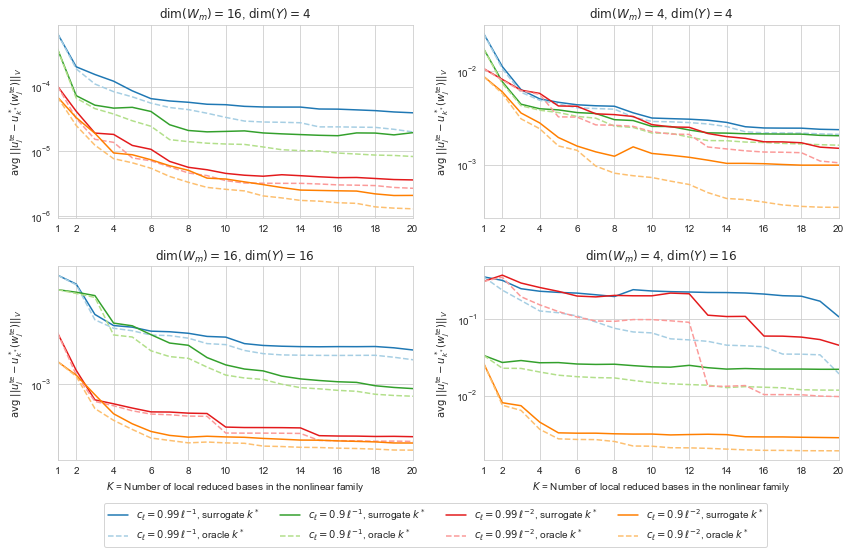

In [16]:
import matplotlib.ticker as ticker
ss = [1,2]
a_bars = [1.0]
gammas = [0.99, 0.9]
field_divs = [1,2]
num_splits = [20]
spacing_divs = [5, 6]
lss = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
majors = [1., 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4]

ax_handles = []
ax_labels = []
cp = sns.color_palette("Paired")
fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace = 0.25)
for k, field_div_load in enumerate(field_divs):
    for l, spacing_div_load in enumerate(spacing_divs):
        ax=axs[k,l]
        for i, s_load in enumerate(ss):
            for a_bar_load in a_bars:
                for num_splits_load in num_splits:
                    for j, gamma_load in enumerate(gammas):

                        d_load = 2**(2*field_div_load)
    
                        file_root = './scripts/results/06_greedy_partition_accel'
                        file = f'{file_root}_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        resids_file = f'{file_root}_residuals_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        inf_sups_file = f'{file_root}_inf_sups_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        
                        if os.path.exists(file):

                            err = np.load(file)
                            
                            n_splits = err.shape[2]
                            n_tests = err.shape[3]
                            m = 2 ** (2*(7 - spacing_div_load))
                            
                            best_err = err[0,0,:,:]
                            best_idx = err[0,1,:,:]
                            match_err = err[1,0,:,:]
                            match_idx = err[1,1,:,:]
                            guess_err = err[2,0,:,:]
                            guess_idx = err[2,1,:,:]
                            resid_err = err[3,0,:,:]
                            resid_idx = err[3,1,:,:]
                            
                            
                            if os.path.exists(resids_file) and os.path.exists(inf_sups_file):
                                resids = np.load(resids_file)
                                inf_sups = np.load(inf_sups_file)
                                
                            sigma_max = (resids * inf_sups).max(axis=1)

                            if all(best_err.mean(axis=1) > 0.0):

                                # 10% of split calcs finished
                                valid_splits = np.sum(resid_err == 0, axis=-1) < 0.1 * n_tests

                                
                                surrogate = ax.semilogy(range(1, valid_splits.sum()+1), resid_err[valid_splits].mean(axis=-1), label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, surrogate $k^*$', color=cp[4*i+2*j+1])
                                best = ax.semilogy(range(1, valid_splits.sum()+1), best_err[valid_splits].mean(axis=-1), '--', label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, oracle $k^*$', color=cp[4*i+2*j])
                                #sigma = ax.semilogy(range(1, valid_splits.sum()+1), sigma_max, '--', label=rf'$\varepsilon \mu$', color=cp[4*i+2*j])
                                if l == 0 and k == 0:
                                    ax_handles.append(surrogate)
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, surrogate $k^*$')
                                    ax_handles.append(best)
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, oracle $k^*$')
                                    
                                # label=rf'$c_j = {gamma_load}\, j^{{-{s_load}}}$, oracle choice of $k^*$', 
                                #ax.semilogy(range(valid_splits.sum()), guess_err[valid_splits].mean(axis=-1), '--', lw=1, color=cp[2*i+j])                        

                                #ax.semilogy(range(n_splits), best_err.mean(axis=-1), lss[i], lw=1, color=cp[2*i+j], zorder=2*i)
                                #for ind_err in plot_err.T:
                                #    ax.semilogy(range(n_splits), ind_err, ':', lw=1, color=cp[i], alpha=0.1, zorder=2*i)

                                if k > 0:
                                    ax.set_xlabel(rf'$K$ = Number of local reduced bases in the nonlinear family')
                                ax.set_title(rf'$\mathrm{{dim}}(W_m)={m}$, $\mathrm{{dim}}(Y)={d_load}$')      
                                ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=100))
                                ax.set_ylabel(rf'$\mathrm{{avg}} \,\, || u_j^{{\mathrm{{te}}}} - u^*_{{k^*}}(w_j^{{\mathrm{{te}}}}) ||_V$')
                                bot_log = np.floor(2*np.log10(guess_err[valid_splits].mean(axis=-1).min()))/2
                                top_log = np.ceil(2*np.log10(guess_err[valid_splits].mean(axis=-1).max()))/2
                                #ax.set_ylim([10**bot_log, 10**top_log])
                                #ax.legend(loc=0)
                                ax.set_xlim([1,20])
                                ax.set_xticks([1]+list(range(2,21,2)))
        if k == 0 and l == 0:
            fig.legend(loc='lower center', fancybox=True, ncol=4, bbox_to_anchor=(0.5, -0.035))#, fancybox=True, shadow=True, ncol=5)
                        
#fig.savefig(f'figs/06_test_2_bulk_results_{2 ** (2*(7 - spacing_div_load))}_{2**(2*field_div_load)}.pdf')
#fig.savefig(f'figs/06_test_2_bulk_results_{2 ** (2*(7 - spacing_div_load))}_{2**(2*field_div_load)}.png')
#, bbox_to_anchor=(2, 0),loc = 'lower right')#handles, ['oral', 'physa'], bbox_to_anchor=(2, 0),loc = 'lower right')
fig.savefig(f'figs/06_test_2_bulk_results.pdf', bbox_inches='tight')
fig.savefig(f'figs/06_test_2_bulk_results.png', bbox_inches='tight')
plt.show()

# Plot the $\sigma$ error bounds of the whole tree

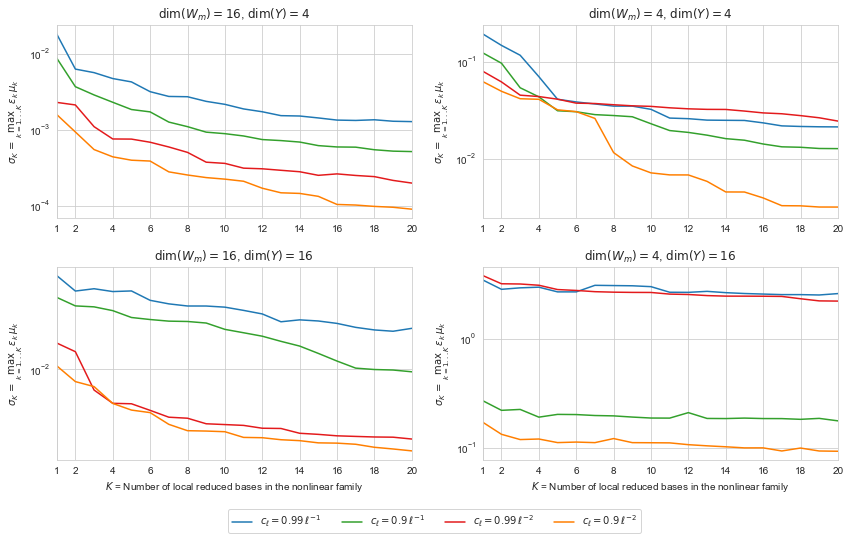

In [24]:
import matplotlib.ticker as ticker
ss = [1,2]
a_bars = [1.0]
gammas = [0.99, 0.9]
field_divs = [1,2]
num_splits = [20]
spacing_divs = [5, 6]
lss = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
majors = [1., 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4]
import shutil

cp = sns.color_palette("Paired")
fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace = 0.25)
for k, field_div_load in enumerate(field_divs):
    for l, spacing_div_load in enumerate(spacing_divs):
        ax=axs[k,l]
        for i, s_load in enumerate(ss):
            for a_bar_load in a_bars:
                for num_splits_load in num_splits:
                    for j, gamma_load in enumerate(gammas):

                        d_load = 2**(2*field_div_load)
                        m = 2 ** (2*(7 - spacing_div_load))
    
                        file_root = './scripts/results/06_greedy_partition_accel'
                        resids_file = f'{file_root}_residuals_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        inf_sups_file = f'{file_root}_inf_sups_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        
                        if os.path.exists(resids_file) and os.path.exists(inf_sups_file):

                            resids = np.load(resids_file)
                            inf_sups = np.load(inf_sups_file)
                            sigma_max = (resids * inf_sups).max(axis=1)

                            sigma = ax.semilogy(range(1, valid_splits.sum()+1), sigma_max, label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$', color=cp[4*i+2*j+1])
                            
                            if k>0:
                                ax.set_xlabel(rf'$K$ = Number of local reduced bases in the nonlinear family')
                            ax.set_title(rf'$\mathrm{{dim}}(W_m)={m}$, $\mathrm{{dim}}(Y)={d_load}$')      
                            ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=100))
                            ax.set_ylabel(rf'$\sigma_K \, = \, \max_{{k = 1...K}} \, \varepsilon_k \, \mu_k$')
                            bot_log = np.floor(2*np.log10(guess_err[valid_splits].mean(axis=-1).min()))/2
                            top_log = np.ceil(2*np.log10(guess_err[valid_splits].mean(axis=-1).max()))/2
                            #ax.set_ylim([10**bot_log, 10**top_log])
                            #ax.legend(loc=0)
                            ax.set_xlim([1,20])
                            ax.set_xticks([1]+list(range(2,21,2)))
        if k == 0 and l == 0:
            fig.legend(loc='lower center', fancybox=True, ncol=4, bbox_to_anchor=(0.5, -0.01))#, fancybox=True, shadow=True, ncol=5)

fig.savefig(f'figs/06_test_2_sigma.pdf',bbox_inches='tight')
fig.savefig(f'figs/06_test_2_sigma.png',bbox_inches='tight')
plt.show()

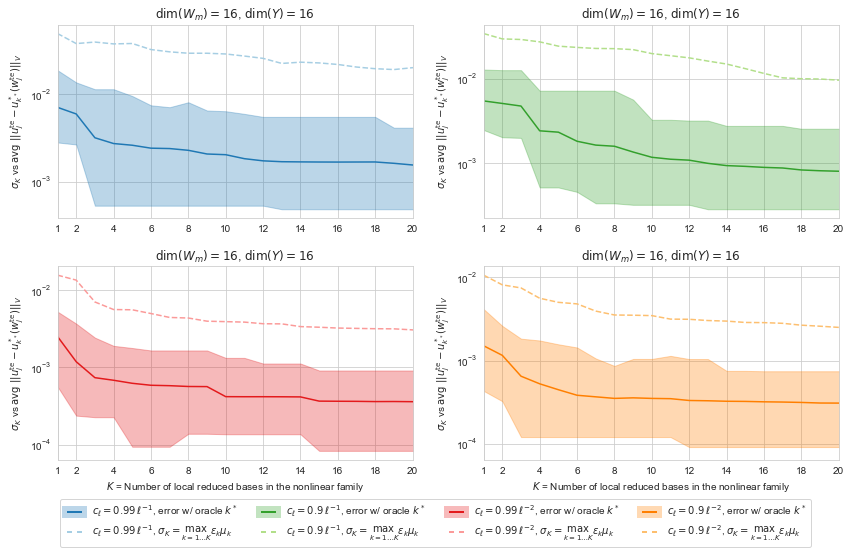

In [23]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc

ss = [1,2]
a_bars = [1.0]
gammas = [0.99, 0.9]
field_divs = [2]
num_splits = [20]
spacing_divs = [5]
lss = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
majors = [1., 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4]

ax_handles = []
ax_labels = []
cp = sns.color_palette("Paired")
fig, axs = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace = 0.25)
for k, field_div_load in enumerate(field_divs):
    for l, spacing_div_load in enumerate(spacing_divs):
        for i, s_load in enumerate(ss):
            for a_bar_load in a_bars:
                for num_splits_load in num_splits:
                    for j, gamma_load in enumerate(gammas):
                        ax = axs[i,j]

                        d_load = 2**(2*field_div_load)
    
                        file_root = './scripts/results/06_greedy_partition_accel'
                        file = f'{file_root}_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        resids_file = f'{file_root}_residuals_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        inf_sups_file = f'{file_root}_inf_sups_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        
                        if os.path.exists(file) and os.path.exists(resids_file) and os.path.exists(inf_sups_file):

                            resids = np.load(resids_file)
                            inf_sups = np.load(inf_sups_file)
                            sigma_max = (resids * inf_sups).max(axis=1)

                            err = np.load(file)
                            
                            n_splits = err.shape[2]
                            n_tests = err.shape[3]
                            m = 2 ** (2*(7 - spacing_div_load))
                            
                            best_err = err[0,0,:,:]
                            best_idx = err[0,1,:,:]
                            match_err = err[1,0,:,:]
                            match_idx = err[1,1,:,:]
                            guess_err = err[2,0,:,:]
                            guess_idx = err[2,1,:,:]
                            resid_err = err[3,0,:,:]
                            resid_idx = err[3,1,:,:]

                            if all(best_err.mean(axis=1) > 0.0):

                                # 10% of split calcs finished
                                valid_splits = np.sum(resid_err == 0, axis=-1) < 0.1 * n_tests

                                resid = ax.semilogy(range(1, valid_splits.sum()+1), best_err[valid_splits].mean(axis=-1), label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, error w/ oracle $k^*$', color=cp[4*i+2*j+1])
                                fill = ax.fill_between(range(1, valid_splits.sum()+1), best_err[valid_splits].min(axis=-1), best_err[valid_splits].max(axis=-1), color=cp[4*i+2*j+1], alpha=.3) 
                                sigma = ax.semilogy(range(1, valid_splits.sum()+1), sigma_max, '--', label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, $\sigma_K = \max_k \varepsilon_k \mu_k$', color=cp[4*i+2*j])
                                if l == 0 and k == 0:
                                    ax_handles.append(best)
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, error w/ oracle $k^*$')
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, $\sigma_K = \max_{{k=1\ldots K}} \varepsilon_k \mu_k$')
                                if i>0:
                                    ax.set_xlabel(rf'$K$ = Number of local reduced bases in the nonlinear family')
                                ax.set_title(rf'$\mathrm{{dim}}(W_m)={m}$, $\mathrm{{dim}}(Y)={d_load}$')      
                                ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=100))
                                ax.set_ylabel(rf'$\sigma_K$ vs $\mathrm{{avg}} \,\, || u_j^{{\mathrm{{te}}}} - u^*_{{k^*}}(w_j^{{\mathrm{{te}}}}) ||_V$')
                                bot_log = np.floor(2*np.log10(guess_err[valid_splits].mean(axis=-1).min()))/2
                                top_log = np.ceil(2*np.log10(guess_err[valid_splits].mean(axis=-1).max()))/2
                                ax.set_xlim([1,20])
                                ax.set_xticks([1]+list(range(2,21,2)))                    
                                
class LegendObject(object):
    def __init__(self, facecolor='red', edgecolor='white', dashed=False):
        self.facecolor = facecolor
        self.edgecolor = edgecolor
        self.dashed = dashed
 
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            # create a rectangle that is filled with color
            [x0, y0], width, height, facecolor=self.facecolor,
            # and whose edges are the faded color
            edgecolor=self.edgecolor, lw=5)
        handlebox.add_artist(patch)
 
        # if we're creating the legend for a dashed line,
        # manually add the dash in to our rectangle
        if self.dashed:
            patch1 = mpatches.Rectangle(
                [x0 + 2*width/5, y0], width/5, height, facecolor=self.edgecolor,
                transform=handlebox.get_transform())
            handlebox.add_artist(patch1)
 
        return patch
 
bg = np.array([1, 1, 1])  # background of the legend is white
colors = [col for col in cp[:4]]
# with alpha = .5, the faded color is the average of the background and color
colors_faded = [0.3*np.array(cc.to_rgb(color)) + 0.7*bg for color in cp[:8]]
 
fig.legend([0, 1, 2, 3, 4, 5, 6, 7], ax_labels,
           handler_map={
               0: LegendObject(cp[1], colors_faded[1]),
               1: LegendObject(cp[0], bg, dashed=True),
               2: LegendObject(cp[3], colors_faded[3]),
               3: LegendObject(cp[2], bg, dashed=True),
               4: LegendObject(cp[5], colors_faded[5]),
               5: LegendObject(cp[4], bg, dashed=True),
               6: LegendObject(cp[7], colors_faded[7]),
               7: LegendObject(cp[6], bg, dashed=True),
            }, loc='lower center', fancybox=True, ncol=4,bbox_to_anchor=(0.5, -0.035))

#fig.legend(loc='lower center', fancybox=True, ncol=4)

fig.savefig(f'figs/06_test_error_sigma_compare.pdf',bbox_inches='tight')
fig.savefig(f'figs/06_test_error_sigma_compare.png',bbox_inches='tight')
plt.show()

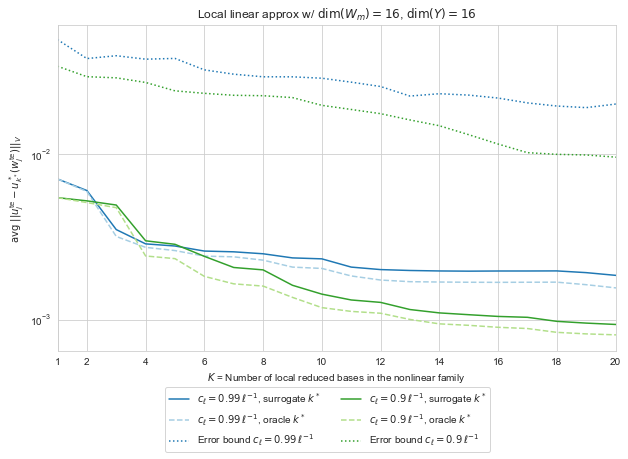

In [18]:
import matplotlib.ticker as ticker
ss = [1]
a_bars = [1.0]
gammas = [0.99, 0.9]
field_divs = [2]
num_splits = [20]
spacing_divs = [5]
lss = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
majors = [1., 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 1e-4]

ax_handles = []
ax_labels = []
cp = sns.color_palette("Paired")
fig, axs = plt.subplots(1, 1, figsize=(10,6))
plt.subplots_adjust(hspace = 0.25)
for k, field_div_load in enumerate(field_divs):
    for l, spacing_div_load in enumerate(spacing_divs):
        ax=axs
        for i, s_load in enumerate(ss):
            for a_bar_load in a_bars:
                for num_splits_load in num_splits:
                    for j, gamma_load in enumerate(gammas):

                        d_load = 2**(2*field_div_load)
    
                        file_root = './scripts/results/06_greedy_partition_accel'
                        file = f'{file_root}_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        resids_file = f'{file_root}_residuals_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        inf_sups_file = f'{file_root}_inf_sups_{d_load}_{a_bar_load}_{gamma_load}_{spacing_div_load}_{num_splits_load}_{s_load}.npy'
                        
                        if os.path.exists(file):

                            err = np.load(file)
                            
                            n_splits = err.shape[2]
                            n_tests = err.shape[3]
                            m = 2 ** (2*(7 - spacing_div_load))
                            
                            best_err = err[0,0,:,:]
                            best_idx = err[0,1,:,:]
                            match_err = err[1,0,:,:]
                            match_idx = err[1,1,:,:]
                            guess_err = err[2,0,:,:]
                            guess_idx = err[2,1,:,:]
                            resid_err = err[3,0,:,:]
                            resid_idx = err[3,1,:,:]
                                
                            if os.path.exists(resids_file) and os.path.exists(inf_sups_file):
                                resids = np.load(resids_file)
                                inf_sups = np.load(inf_sups_file)
                                
                            sigma_max = (resids * inf_sups).max(axis=1)

                            if all(best_err.mean(axis=1) > 0.0):

                                # 10% of split calcs finished
                                valid_splits = np.sum(resid_err == 0, axis=-1) < 0.1 * n_tests

                                
                                surrogate = ax.semilogy(range(1, valid_splits.sum()+1), resid_err[valid_splits].mean(axis=-1), label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, surrogate $k^*$', color=cp[4*i+2*j+1])
                                best = ax.semilogy(range(1, valid_splits.sum()+1), best_err[valid_splits].mean(axis=-1), '--', label=rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, oracle $k^*$', color=cp[4*i+2*j])
                                #sigma = ax.semilogy(range(1, valid_splits.sum()+1), sigma_max, '--', label=rf'$\varepsilon \mu$', color=cp[4*i+2*j])
                                if l == 0 and k == 0:
                                    ax_handles.append(surrogate)
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, surrogate $k^*$')
                                    ax_handles.append(best)
                                    ax_labels.append(rf'$c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$, oracle $k^*$')
                                    
                                # label=rf'$c_j = {gamma_load}\, j^{{-{s_load}}}$, oracle choice of $k^*$', 
                                #ax.semilogy(range(valid_splits.sum()), guess_err[valid_splits].mean(axis=-1), '--', lw=1, color=cp[2*i+j])                        
                                
                                sigma = ax.semilogy(range(1, valid_splits.sum()+1), sigma_max,  ':', label=rf'Error bound $c_\ell = {gamma_load}\, \ell^{{-{s_load}}}$', color=cp[4*i+2*j+1])
                            

                                #ax.semilogy(range(n_splits), best_err.mean(axis=-1), lss[i], lw=1, color=cp[2*i+j], zorder=2*i)
                                #for ind_err in plot_err.T:
                                #    ax.semilogy(range(n_splits), ind_err, ':', lw=1, color=cp[i], alpha=0.1, zorder=2*i)

                                ax.set_xlabel(rf'$K$ = Number of local reduced bases in the nonlinear family')
                                ax.set_title(rf'Local linear approx w/ $\mathrm{{dim}}(W_m)=16$, $\mathrm{{dim}}(Y)=16$')      
                                ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=100))
                                ax.set_ylabel(rf'$\mathrm{{avg}} \,\, || u_j^{{\mathrm{{te}}}} - u^*_{{k^*}}(w_j^{{\mathrm{{te}}}}) ||_V$')
                                bot_log = np.floor(2*np.log10(guess_err[valid_splits].mean(axis=-1).min()))/2
                                top_log = np.ceil(2*np.log10(guess_err[valid_splits].mean(axis=-1).max()))/2
                                #ax.set_ylim([10**bot_log, 10**top_log])
                                #ax.legend(loc=0)
                                ax.set_xlim([1,20])
                                ax.set_xticks([1]+list(range(2,21,2)))
        if k == 0 and l == 0:
            fig.legend(loc='lower center', fancybox=True, ncol=2, bbox_to_anchor=(0.5, -0.12))#, fancybox=True, shadow=True, ncol=5)
                        
#fig.savefig(f'figs/06_test_2_bulk_results_{2 ** (2*(7 - spacing_div_load))}_{2**(2*field_div_load)}.pdf')
#fig.savefig(f'figs/06_test_2_bulk_results_{2 ** (2*(7 - spacing_div_load))}_{2**(2*field_div_load)}.png')
#, bbox_to_anchor=(2, 0),loc = 'lower right')#handles, ['oral', 'physa'], bbox_to_anchor=(2, 0),loc = 'lower right')
fig.savefig(f'figs/nonlinear_bulk_test.pdf', bbox_inches='tight')
plt.show()